In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install yolov5
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import yolov5
import PIL


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = yolov5.load('keremberke/yolov5m-license-plate')
model = model.to(device)

model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image


config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

In [ ]:
import datasets

dataset_name = 'keremberke/license-plate-object-detection'

dataset = datasets.load_dataset(dataset_name, 'full')


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def non_detection_objective(predictions):
    # Extract confidence scores
    confidences = torch.sigmoid(predictions[..., 4])  # Objectness scores are at index 4
    return confidences.sum()


In [ ]:
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
import random

def apply_patch(image, patch, position=(0, 0)):
    patch_image = transforms.ToPILImage()(patch.detach())
    image = image.copy().resize((640, 640))
    image.paste(patch_image, position)
    return image



def randomize_patch_parameters(image_size, patch_size, min_scale=1.0, max_scale=1.0):
    """
    Generate random scale and position for the patch.
    Args:
    - image_size: Tuple (image_height, image_width)
    - patch_size: Tuple (patch_height, patch_width)
    - max_scale: Maximum scaling factor for the patch
    Returns:
    - scale: Random scale factor
    - position: Random position (top, left)
    """
    image_height, image_width = image_size
    patch_height, patch_width = patch_size

    # Random scale
    scale = random.uniform(min_scale, max_scale)
    scaled_patch_height, scaled_patch_width = int(scale * patch_height), int(scale * patch_width)

    # Random position ensuring the scaled patch fits within the image
    top = random.randint(0, max(0, image_height - scaled_patch_height))
    left = random.randint(0, max(0, image_width - scaled_patch_width))

    return scale, (top, left)


def apply_patch_to_batch(batch_images, patch, position=(0, 0), scale=1.0):
    """
    Apply the full patch to a batch of images with scaling.
    Args:
    - batch_images: Tensor of shape [batch_size, 3, height, width]
    - patch: Tensor of shape [3, patch_height, patch_width]
    - position: Tuple (top, left) indicating where to place the patch
    - scale: Scaling factor for the patch
    """
    batch_size, _, height, width = batch_images.size()

    patch_height, patch_width = patch.shape[1], patch.shape[2]
    scaled_patch_height, scaled_patch_width = int(scale * patch_height), int(scale * patch_width)
    scaled_patch = F.resize(patch, [scaled_patch_height, scaled_patch_width])

    top, left = position
    top = max(0, min(top, height - scaled_patch_height))
    left = max(0, min(left, width - scaled_patch_width))

    mask = torch.zeros_like(batch_images)
    mask[:, :, top:top+scaled_patch_height, left:left+scaled_patch_width] = 1

    patched_mask = torch.zeros_like(batch_images)
    patched_mask[:, :, top:top+scaled_patch_height, left:left+scaled_patch_width] = scaled_patch

    return (batch_images * (1 - mask) + patched_mask).to(device)


In [ ]:
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])


In [ ]:
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transforms=None):
        self.hf_dataset = hf_dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']

        if self.transforms:
            image = self.transforms(image)

        return image


In [ ]:
import gc
import os
import tqdm


In [ ]:
PATCH_CHECKPOINT_PATH = '/content/drive/Othercomputers/MacbookAir/projects/Licence-Plates-Det-Attacks/patch_ckpt.pt'


if os.path.exists(PATCH_CHECKPOINT_PATH):
  patch = torch.load(PATCH_CHECKPOINT_PATH)
  patch_size = tuple(patch.shape)[1:]
  print(f"Loading patch of size {patch_size} from checkpoint")
else:
  patch_size = (100, 100)
  patch = torch.rand((3, *patch_size), requires_grad=True, device=device)


Loading patch of size (100, 100) from checkpoint


In [ ]:
batch_size = 30
lr = 0.1
epochs = 10

transformed_dataset = HFDataset(dataset['train'], transform)
data_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam([patch], lr=lr)

model_ = model.model.model

model_.train()

image_size = (640, 640)

losses = []

progress_iter = 20

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    optimizer.zero_grad()
    epoch_loss = 0.0
    for i, batch in enumerate(tqdm.tqdm(data_loader, miniters=progress_iter)):
      gc.collect()
      torch.cuda.empty_cache()

      total_loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
      scale, position = randomize_patch_parameters(image_size, patch_size, min_scale=0.5, max_scale=1.0)
      patched_imgs = apply_patch_to_batch(batch, patch, position=position, scale=scale)

      result = model_(patched_imgs)

      for r in result:
        total_loss = total_loss + non_detection_objective(r)

      epoch_loss += total_loss.cpu().item()
      total_loss.backward()
      optimizer.step()

      if i % progress_iter == 0:
        print('batch loss:', total_loss.cpu().item())

      torch.save(patch, PATCH_CHECKPOINT_PATH)

    losses.append(epoch_loss)
    print('epoch loss:', epoch_loss)


Epoch 0


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 384.7581787109375


  5%|▌         | 11/206 [00:18<05:23,  1.66s/it]

batch loss: 395.7337646484375


 10%|█         | 21/206 [00:36<05:01,  1.63s/it]

batch loss: 370.39483642578125


 15%|█▌        | 31/206 [00:53<04:49,  1.65s/it]

batch loss: 328.31414794921875


 20%|█▉        | 41/206 [01:10<04:31,  1.65s/it]

batch loss: 341.84478759765625


 25%|██▍       | 51/206 [01:28<04:19,  1.67s/it]

batch loss: 249.35565185546875


 30%|██▉       | 61/206 [01:47<04:23,  1.81s/it]

batch loss: 361.0390625


 34%|███▍      | 71/206 [02:05<03:46,  1.68s/it]

batch loss: 403.0796813964844


 39%|███▉      | 81/206 [02:22<03:41,  1.77s/it]

batch loss: 483.2093200683594


 44%|████▍     | 91/206 [02:40<03:23,  1.77s/it]

batch loss: 360.78643798828125


 49%|████▉     | 101/206 [02:58<03:06,  1.78s/it]

batch loss: 427.2690124511719


 54%|█████▍    | 111/206 [03:15<02:49,  1.78s/it]

batch loss: 452.00732421875


 59%|█████▊    | 121/206 [03:33<02:35,  1.83s/it]

batch loss: 344.3629150390625


 64%|██████▎   | 131/206 [03:51<02:19,  1.86s/it]

batch loss: 546.290283203125


 68%|██████▊   | 141/206 [04:08<02:01,  1.87s/it]

batch loss: 301.3338623046875


 73%|███████▎  | 151/206 [04:26<01:42,  1.86s/it]

batch loss: 388.728271484375


 78%|███████▊  | 161/206 [04:44<01:25,  1.89s/it]

batch loss: 387.0365295410156


 83%|████████▎ | 171/206 [05:01<01:06,  1.90s/it]

batch loss: 454.8371276855469


 88%|████████▊ | 181/206 [05:19<00:47,  1.91s/it]

batch loss: 602.2989501953125


 93%|█████████▎| 191/206 [05:37<00:29,  1.94s/it]

batch loss: 370.44598388671875


 98%|█████████▊| 201/206 [05:54<00:09,  1.85s/it]

batch loss: 361.75341796875


100%|██████████| 206/206 [06:03<00:00,  1.76s/it]


epoch loss: 80465.02926635742
Epoch 1


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 384.3339538574219


  5%|▌         | 11/206 [00:22<07:01,  2.16s/it]

batch loss: 402.87530517578125


 10%|█         | 21/206 [00:40<05:48,  1.88s/it]

batch loss: 291.336181640625


 15%|█▌        | 31/206 [00:57<05:28,  1.88s/it]

batch loss: 330.6961669921875


 20%|█▉        | 41/206 [01:15<05:13,  1.90s/it]

batch loss: 272.9484558105469


 25%|██▍       | 51/206 [01:32<04:52,  1.89s/it]

batch loss: 561.1425170898438


 30%|██▉       | 61/206 [01:50<04:40,  1.94s/it]

batch loss: 439.65576171875


 34%|███▍      | 71/206 [02:08<04:11,  1.87s/it]

batch loss: 430.44171142578125


 39%|███▉      | 81/206 [02:25<03:49,  1.83s/it]

batch loss: 346.85693359375


 44%|████▍     | 91/206 [02:42<03:26,  1.80s/it]

batch loss: 340.67645263671875


 49%|████▉     | 101/206 [03:00<03:11,  1.83s/it]

batch loss: 462.303955078125


 54%|█████▍    | 111/206 [03:18<02:50,  1.80s/it]

batch loss: 411.9015197753906


 59%|█████▊    | 121/206 [03:35<02:29,  1.76s/it]

batch loss: 501.0805969238281


 64%|██████▎   | 131/206 [03:52<02:10,  1.74s/it]

batch loss: 519.197998046875


 68%|██████▊   | 141/206 [04:10<01:52,  1.73s/it]

batch loss: 566.1435546875


 73%|███████▎  | 151/206 [04:27<01:35,  1.74s/it]

batch loss: 381.37750244140625


 78%|███████▊  | 161/206 [04:44<01:18,  1.74s/it]

batch loss: 412.90869140625


 83%|████████▎ | 171/206 [05:02<00:59,  1.71s/it]

batch loss: 450.54327392578125


 88%|████████▊ | 181/206 [05:19<00:42,  1.72s/it]

batch loss: 263.1051025390625


 93%|█████████▎| 191/206 [05:37<00:25,  1.70s/it]

batch loss: 619.1907348632812


 98%|█████████▊| 201/206 [05:54<00:08,  1.69s/it]

batch loss: 441.590576171875


100%|██████████| 206/206 [06:03<00:00,  1.76s/it]


epoch loss: 83073.2836303711
Epoch 2


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 466.40484619140625


  5%|▌         | 11/206 [00:19<06:02,  1.86s/it]

batch loss: 505.2627258300781


 10%|█         | 21/206 [00:36<05:46,  1.87s/it]

batch loss: 434.8371887207031


 15%|█▌        | 31/206 [00:54<05:31,  1.90s/it]

batch loss: 405.1684875488281


 20%|█▉        | 41/206 [01:11<05:07,  1.86s/it]

batch loss: 550.9805908203125


 25%|██▍       | 51/206 [01:29<04:46,  1.85s/it]

batch loss: 369.59381103515625


 30%|██▉       | 61/206 [01:46<04:27,  1.85s/it]

batch loss: 395.5489196777344


 34%|███▍      | 71/206 [02:03<04:06,  1.83s/it]

batch loss: 330.39166259765625


 39%|███▉      | 81/206 [02:21<03:42,  1.78s/it]

batch loss: 414.03143310546875


 44%|████▍     | 91/206 [02:38<03:16,  1.70s/it]

batch loss: 485.7627258300781


 49%|████▉     | 101/206 [02:55<02:58,  1.70s/it]

batch loss: 412.875244140625


 54%|█████▍    | 111/206 [03:12<02:38,  1.67s/it]

batch loss: 343.2881774902344


 59%|█████▊    | 121/206 [03:29<02:20,  1.65s/it]

batch loss: 411.935791015625


 64%|██████▎   | 131/206 [03:46<02:04,  1.66s/it]

batch loss: 404.8616027832031


 68%|██████▊   | 141/206 [04:03<01:45,  1.62s/it]

batch loss: 265.0982971191406


 73%|███████▎  | 151/206 [04:21<01:36,  1.75s/it]

batch loss: 394.54815673828125


 78%|███████▊  | 161/206 [04:38<01:21,  1.81s/it]

batch loss: 427.1457214355469


 83%|████████▎ | 171/206 [04:55<01:03,  1.83s/it]

batch loss: 321.42205810546875


 88%|████████▊ | 181/206 [05:12<00:44,  1.78s/it]

batch loss: 424.8986511230469


 93%|█████████▎| 191/206 [05:29<00:26,  1.77s/it]

batch loss: 530.37060546875


 98%|█████████▊| 201/206 [05:46<00:08,  1.72s/it]

batch loss: 413.1575927734375


100%|██████████| 206/206 [05:55<00:00,  1.73s/it]


epoch loss: 81368.7332611084
Epoch 3


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 384.57135009765625


  5%|▌         | 11/206 [00:19<05:49,  1.79s/it]

batch loss: 381.6527404785156


 10%|█         | 21/206 [00:36<05:27,  1.77s/it]

batch loss: 301.153076171875


 15%|█▌        | 31/206 [00:53<05:00,  1.72s/it]

batch loss: 405.59869384765625


 20%|█▉        | 41/206 [01:10<04:40,  1.70s/it]

batch loss: 397.1820983886719


 25%|██▍       | 51/206 [01:27<04:17,  1.66s/it]

batch loss: 383.01904296875


 30%|██▉       | 61/206 [01:44<03:59,  1.65s/it]

batch loss: 420.2149963378906


 34%|███▍      | 71/206 [02:01<03:38,  1.62s/it]

batch loss: 567.0618896484375


 39%|███▉      | 81/206 [02:18<03:24,  1.64s/it]

batch loss: 421.669189453125


 44%|████▍     | 91/206 [02:36<03:23,  1.77s/it]

batch loss: 337.80914306640625


 49%|████▉     | 101/206 [02:53<03:11,  1.83s/it]

batch loss: 517.5640869140625


 54%|█████▍    | 111/206 [03:11<02:57,  1.87s/it]

batch loss: 378.81317138671875


 59%|█████▊    | 121/206 [03:28<02:31,  1.78s/it]

batch loss: 249.47750854492188


 64%|██████▎   | 131/206 [03:45<02:11,  1.76s/it]

batch loss: 355.8253173828125


 68%|██████▊   | 141/206 [04:02<01:49,  1.69s/it]

batch loss: 396.68408203125


 73%|███████▎  | 151/206 [04:19<01:31,  1.67s/it]

batch loss: 301.69012451171875


 78%|███████▊  | 161/206 [04:36<01:14,  1.65s/it]

batch loss: 470.77349853515625


 83%|████████▎ | 171/206 [04:53<00:56,  1.61s/it]

batch loss: 437.81146240234375


 88%|████████▊ | 181/206 [05:11<00:41,  1.66s/it]

batch loss: 486.02862548828125


 93%|█████████▎| 191/206 [05:28<00:27,  1.82s/it]

batch loss: 398.8393249511719


 98%|█████████▊| 201/206 [05:46<00:09,  1.83s/it]

batch loss: 446.6782531738281


100%|██████████| 206/206 [05:54<00:00,  1.72s/it]


epoch loss: 85998.72863769531
Epoch 4


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 436.3802185058594


  5%|▌         | 11/206 [00:18<05:25,  1.67s/it]

batch loss: 410.6852111816406


 10%|█         | 21/206 [00:36<05:21,  1.74s/it]

batch loss: 455.29571533203125


 15%|█▌        | 31/206 [00:53<05:11,  1.78s/it]

batch loss: 414.0599060058594


 20%|█▉        | 41/206 [01:11<05:03,  1.84s/it]

batch loss: 412.2000427246094


 25%|██▍       | 51/206 [01:28<04:39,  1.80s/it]

batch loss: 313.91900634765625


 30%|██▉       | 61/206 [01:45<04:16,  1.77s/it]

batch loss: 558.5003662109375


 34%|███▍      | 71/206 [02:02<03:49,  1.70s/it]

batch loss: 516.7193603515625


 39%|███▉      | 81/206 [02:19<03:28,  1.67s/it]

batch loss: 339.59210205078125


 44%|████▍     | 91/206 [02:36<03:10,  1.66s/it]

batch loss: 368.18646240234375


 49%|████▉     | 101/206 [02:54<02:55,  1.67s/it]

batch loss: 343.8749084472656


 54%|█████▍    | 111/206 [03:11<02:36,  1.65s/it]

batch loss: 356.32061767578125


 59%|█████▊    | 121/206 [03:28<02:25,  1.72s/it]

batch loss: 286.7652587890625


 64%|██████▎   | 131/206 [03:46<02:14,  1.79s/it]

batch loss: 343.1336669921875


 68%|██████▊   | 141/206 [04:03<02:00,  1.85s/it]

batch loss: 391.6001892089844


 73%|███████▎  | 151/206 [04:20<01:39,  1.81s/it]

batch loss: 531.3985595703125


 78%|███████▊  | 161/206 [04:37<01:17,  1.72s/it]

batch loss: 427.78369140625


 83%|████████▎ | 171/206 [04:53<00:58,  1.68s/it]

batch loss: 232.4889373779297


 88%|████████▊ | 181/206 [05:11<00:41,  1.67s/it]

batch loss: 458.8221130371094


 93%|█████████▎| 191/206 [05:27<00:24,  1.65s/it]

batch loss: 315.0827941894531


 98%|█████████▊| 201/206 [05:44<00:08,  1.62s/it]

batch loss: 430.6380310058594


100%|██████████| 206/206 [05:53<00:00,  1.72s/it]


epoch loss: 85898.86492919922
Epoch 5


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 434.8880615234375


  5%|▌         | 11/206 [00:18<05:26,  1.68s/it]

batch loss: 413.1622314453125


 10%|█         | 21/206 [00:35<05:04,  1.65s/it]

batch loss: 584.0936889648438


 15%|█▌        | 31/206 [00:52<04:45,  1.63s/it]

batch loss: 352.06866455078125


 20%|█▉        | 41/206 [01:09<04:28,  1.63s/it]

batch loss: 420.01666259765625


 25%|██▍       | 51/206 [01:26<04:10,  1.61s/it]

batch loss: 406.0941467285156


 30%|██▉       | 61/206 [01:43<04:01,  1.67s/it]

batch loss: 330.888427734375


 34%|███▍      | 71/206 [02:00<03:55,  1.74s/it]

batch loss: 348.4849853515625


 39%|███▉      | 81/206 [02:18<03:47,  1.82s/it]

batch loss: 345.06536865234375


 44%|████▍     | 91/206 [02:35<03:33,  1.86s/it]

batch loss: 477.3896484375


 49%|████▉     | 101/206 [02:52<03:04,  1.76s/it]

batch loss: 372.1588134765625


 54%|█████▍    | 111/206 [03:09<02:41,  1.70s/it]

batch loss: 475.4573059082031


 59%|█████▊    | 121/206 [03:26<02:22,  1.68s/it]

batch loss: 399.1763000488281


 64%|██████▎   | 131/206 [03:43<02:05,  1.67s/it]

batch loss: 595.6162719726562


 68%|██████▊   | 141/206 [04:00<01:48,  1.66s/it]

batch loss: 382.24688720703125


 73%|███████▎  | 151/206 [04:17<01:29,  1.62s/it]

batch loss: 396.2913818359375


 78%|███████▊  | 161/206 [04:34<01:12,  1.61s/it]

batch loss: 552.67919921875


 83%|████████▎ | 171/206 [04:51<01:00,  1.73s/it]

batch loss: 454.23291015625


 88%|████████▊ | 181/206 [05:09<00:44,  1.80s/it]

batch loss: 388.76165771484375


 93%|█████████▎| 191/206 [05:26<00:28,  1.88s/it]

batch loss: 557.3477172851562


 98%|█████████▊| 201/206 [05:43<00:08,  1.78s/it]

batch loss: 179.99740600585938


100%|██████████| 206/206 [05:51<00:00,  1.71s/it]


epoch loss: 83996.31295776367
Epoch 6


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 751.67822265625


  5%|▌         | 11/206 [00:18<05:36,  1.72s/it]

batch loss: 468.7715148925781


 10%|█         | 21/206 [00:35<05:23,  1.75s/it]

batch loss: 384.37335205078125


 15%|█▌        | 31/206 [00:53<05:20,  1.83s/it]

batch loss: 428.29010009765625


 20%|█▉        | 41/206 [01:10<05:00,  1.82s/it]

batch loss: 224.77313232421875


 25%|██▍       | 51/206 [01:27<04:31,  1.75s/it]

batch loss: 612.86474609375


 30%|██▉       | 61/206 [01:44<04:07,  1.70s/it]

batch loss: 299.62841796875


 34%|███▍      | 71/206 [02:01<03:48,  1.69s/it]

batch loss: 423.3531494140625


 39%|███▉      | 81/206 [02:18<03:31,  1.69s/it]

batch loss: 417.1171875


 44%|████▍     | 91/206 [02:36<03:09,  1.65s/it]

batch loss: 307.55218505859375


 49%|████▉     | 101/206 [02:53<02:55,  1.67s/it]

batch loss: 323.4979553222656


 54%|█████▍    | 111/206 [03:11<02:46,  1.75s/it]

batch loss: 392.3758239746094


 59%|█████▊    | 121/206 [03:28<02:38,  1.86s/it]

batch loss: 586.1624145507812


 64%|██████▎   | 131/206 [03:46<02:23,  1.92s/it]

batch loss: 468.4294128417969


 68%|██████▊   | 141/206 [04:03<01:56,  1.79s/it]

batch loss: 385.8858642578125


 73%|███████▎  | 151/206 [04:21<01:34,  1.73s/it]

batch loss: 519.1543579101562


 78%|███████▊  | 161/206 [04:38<01:15,  1.69s/it]

batch loss: 715.7327880859375


 83%|████████▎ | 171/206 [04:56<00:58,  1.66s/it]

batch loss: 438.89666748046875


 88%|████████▊ | 181/206 [05:13<00:41,  1.66s/it]

batch loss: 425.22503662109375


 93%|█████████▎| 191/206 [05:30<00:25,  1.69s/it]

batch loss: 236.0076446533203


 98%|█████████▊| 201/206 [05:48<00:08,  1.79s/it]

batch loss: 586.3013916015625


100%|██████████| 206/206 [05:56<00:00,  1.73s/it]


epoch loss: 86253.08871459961
Epoch 7


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 545.5489501953125


  5%|▌         | 11/206 [00:18<05:25,  1.67s/it]

batch loss: 399.2204895019531


 10%|█         | 21/206 [00:36<05:07,  1.66s/it]

batch loss: 381.559326171875


 15%|█▌        | 31/206 [00:53<05:11,  1.78s/it]

batch loss: 379.4235534667969


 20%|█▉        | 41/206 [01:11<05:07,  1.87s/it]

batch loss: 486.6349792480469


 25%|██▍       | 51/206 [01:28<04:45,  1.84s/it]

batch loss: 471.1781311035156


 30%|██▉       | 61/206 [01:45<04:21,  1.80s/it]

batch loss: 420.4747314453125


 34%|███▍      | 71/206 [02:03<03:52,  1.72s/it]

batch loss: 360.10247802734375


 39%|███▉      | 81/206 [02:20<03:30,  1.68s/it]

batch loss: 377.9032287597656


 44%|████▍     | 91/206 [02:37<03:09,  1.65s/it]

batch loss: 611.55078125


 49%|████▉     | 101/206 [02:54<02:51,  1.63s/it]

batch loss: 385.5147705078125


 54%|█████▍    | 111/206 [03:11<02:33,  1.62s/it]

batch loss: 443.2477111816406


 59%|█████▊    | 121/206 [03:29<02:29,  1.76s/it]

batch loss: 576.9553833007812


 64%|██████▎   | 131/206 [03:46<02:17,  1.83s/it]

batch loss: 403.3264465332031


 68%|██████▊   | 141/206 [04:04<02:01,  1.88s/it]

batch loss: 337.90625


 73%|███████▎  | 151/206 [04:21<01:38,  1.79s/it]

batch loss: 424.9969482421875


 78%|███████▊  | 161/206 [04:38<01:17,  1.72s/it]

batch loss: 289.2135009765625


 83%|████████▎ | 171/206 [04:56<01:00,  1.72s/it]

batch loss: 455.19677734375


 88%|████████▊ | 181/206 [05:13<00:41,  1.67s/it]

batch loss: 365.18731689453125


 93%|█████████▎| 191/206 [05:30<00:24,  1.66s/it]

batch loss: 399.3862609863281


 98%|█████████▊| 201/206 [05:48<00:08,  1.64s/it]

batch loss: 454.5599670410156


100%|██████████| 206/206 [05:57<00:00,  1.73s/it]


epoch loss: 83445.8803100586
Epoch 8


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 423.8561706542969


  5%|▌         | 11/206 [00:18<05:25,  1.67s/it]

batch loss: 408.1292419433594


 10%|█         | 21/206 [00:35<05:01,  1.63s/it]

batch loss: 397.298828125


 15%|█▌        | 31/206 [00:53<04:46,  1.64s/it]

batch loss: 589.8485717773438


 20%|█▉        | 41/206 [01:10<04:48,  1.75s/it]

batch loss: 281.4195861816406


 25%|██▍       | 51/206 [01:28<04:44,  1.84s/it]

batch loss: 366.3241271972656


 30%|██▉       | 61/206 [01:45<04:27,  1.85s/it]

batch loss: 700.9146728515625


 34%|███▍      | 71/206 [02:02<03:59,  1.78s/it]

batch loss: 336.2052307128906


 39%|███▉      | 81/206 [02:20<03:36,  1.73s/it]

batch loss: 186.21270751953125


 44%|████▍     | 91/206 [02:37<03:14,  1.69s/it]

batch loss: 451.762939453125


 49%|████▉     | 101/206 [02:54<02:53,  1.66s/it]

batch loss: 382.1915588378906


 54%|█████▍    | 111/206 [03:11<02:35,  1.64s/it]

batch loss: 427.51031494140625


 59%|█████▊    | 121/206 [03:28<02:14,  1.59s/it]

batch loss: 511.7584228515625


 64%|██████▎   | 131/206 [03:45<02:05,  1.67s/it]

batch loss: 304.860107421875


 68%|██████▊   | 141/206 [04:02<01:53,  1.75s/it]

batch loss: 412.5144958496094


 73%|███████▎  | 151/206 [04:19<01:38,  1.78s/it]

batch loss: 450.4132995605469


 78%|███████▊  | 161/206 [04:36<01:22,  1.83s/it]

batch loss: 324.8081970214844


 83%|████████▎ | 171/206 [04:54<01:02,  1.79s/it]

batch loss: 396.7177734375


 88%|████████▊ | 181/206 [05:11<00:42,  1.71s/it]

batch loss: 455.9305114746094


 93%|█████████▎| 191/206 [05:27<00:24,  1.63s/it]

batch loss: 429.7688903808594


 98%|█████████▊| 201/206 [05:44<00:08,  1.64s/it]

batch loss: 378.0525817871094


100%|██████████| 206/206 [05:53<00:00,  1.71s/it]


epoch loss: 82259.96401977539
Epoch 9


  0%|          | 0/206 [00:00<?, ?it/s]

batch loss: 359.2381896972656


  5%|▌         | 11/206 [00:18<05:36,  1.73s/it]

batch loss: 567.7982788085938


 10%|█         | 21/206 [00:35<05:10,  1.68s/it]

batch loss: 326.58807373046875


 15%|█▌        | 31/206 [00:52<04:54,  1.69s/it]

batch loss: 398.280517578125


 20%|█▉        | 41/206 [01:09<04:32,  1.65s/it]

batch loss: 386.217041015625


 25%|██▍       | 51/206 [01:25<04:11,  1.62s/it]

batch loss: 276.4102478027344


 30%|██▉       | 61/206 [01:42<03:53,  1.61s/it]

batch loss: 345.3992614746094


 34%|███▍      | 71/206 [01:59<03:38,  1.62s/it]

batch loss: 319.8605651855469


 39%|███▉      | 81/206 [02:16<03:29,  1.68s/it]

batch loss: 260.1560363769531


 44%|████▍     | 91/206 [02:34<03:18,  1.73s/it]

batch loss: 250.1100616455078


 49%|████▉     | 101/206 [02:51<03:05,  1.77s/it]

batch loss: 440.8740234375


 54%|█████▍    | 111/206 [03:08<02:52,  1.82s/it]

batch loss: 464.97320556640625


 59%|█████▊    | 121/206 [03:25<02:31,  1.78s/it]

batch loss: 334.1462707519531


 64%|██████▎   | 131/206 [03:42<02:08,  1.72s/it]

batch loss: 323.7237548828125


 68%|██████▊   | 141/206 [03:59<01:50,  1.70s/it]

batch loss: 297.62188720703125


 73%|███████▎  | 151/206 [04:16<01:32,  1.68s/it]

batch loss: 401.43841552734375


 78%|███████▊  | 161/206 [04:33<01:15,  1.69s/it]

batch loss: 418.1882629394531


 83%|████████▎ | 171/206 [04:50<00:57,  1.65s/it]

batch loss: 174.40496826171875


 88%|████████▊ | 181/206 [05:07<00:40,  1.63s/it]

batch loss: 235.78602600097656


 93%|█████████▎| 191/206 [05:24<00:24,  1.65s/it]

batch loss: 426.5453796386719


 98%|█████████▊| 201/206 [05:42<00:08,  1.79s/it]

batch loss: 429.4549255371094


100%|██████████| 206/206 [05:50<00:00,  1.70s/it]

epoch loss: 80818.71737670898


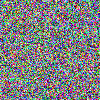

In [ ]:
from torchvision.transforms import ToPILImage
from IPython.display import display

patch_img = ToPILImage()(patch)
display(patch_img)


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image

model.eval()

img = dataset['train'][1]['image']
patched_img = apply_patch(img, patch)

result = model(img.resize((640, 640)))
result.show()

result = model(patched_img)
result.show()
